<a href="https://colab.research.google.com/github/tottorrZ/229352-StatisticalLearning/blob/main/Lab02_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [3]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [ ]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

In [ ]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

### Data Preprocessing

In [4]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Calculate class statistics
print("Class distribution:")
print(df['y'].value_counts(normalize=True))

# Drop 'duration' due to data leakage
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

# Define features (X) and target (y)
X = df.drop(columns=['y'])
y = df['y']

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print data shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Class distribution:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64
X_train shape: (32950, 14)
X_test shape: (8238, 14)
y_train shape: (32950,)
y_test shape: (8238,)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [5]:
num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo]) ## Write your code here

# Transform both training and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])# Write your code here
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])# Write your code here

Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [6]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())


Original X_train 'age' and 'campaign' head:
       age  campaign
25611   49         4
26010   37         2
40194   78         1
297     36         2
36344   59         2

Scaled X_train 'age' and 'campaign' head:
            age  campaign
25611  0.863739  0.522981
26010 -0.289722 -0.203688
40194  3.651268 -0.567023
297   -0.385843 -0.203688
36344  1.824956 -0.203688

Mean of scaled 'age' (train): 2.5106202734710067e-16
Std Dev of scaled 'campaign' (train): 1.0


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [7]:
ord_col_demo = ['education']

imputer_ord = SimpleImputer(strategy='most_frequent')

## Write your code here
imputer_ord.fit(X_train[ord_col_demo]) ## Write your code here

# Fit imputer only on training AND test data
X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo]) # Write your code here
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo]) # Write your code here

- **Ordinal Encoding**

In [8]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [9]:
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

## Write your code here
ordinal_encoder.fit(X_train_imputed_ord_demo) ## Write your code here

# Transform both imputed training and test data
X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo) # Write your code here
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo) # Write your code here

Let's take a look at the imputed and ordinal-encoded `education`.

In [10]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])


Original X_train 'education' head:
               education
20441                NaN
32051           basic.4y
12588           basic.6y
5656                 NaN
39224  university.degree

Imputed X_train 'education' head (after imputer.transform):
               education
20441  university.degree
32051           basic.4y
12588           basic.6y
5656   university.degree
39224  university.degree

Ordinal Encoded X_train 'education' head:
       education
20441        6.0
32051        1.0
12588        2.0
5656         6.0
39224        6.0


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [11]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [14]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Write your code here
onehot_encoder.fit(X_train_imputed_nom_demo) ## Write your code here

# Transform both imputed training and test data
X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo) ## Write your code here
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo) ## Write your code here

In [15]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])


Original X_train 'job' head:
               job
32095  blue-collar
1817    technician
30362   technician
23737          NaN
9454        admin.

Imputed X_train 'job' head (after imputer.transform):
               job
32095  blue-collar
1817    technician
30362   technician
23737       admin.
9454        admin.

One-Hot Encoded X_train 'job' shape: (32950, 11)
First 5 rows of One-Hot Encoded X_train 'job':
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
32095         0.0              1.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
1817          0.0              0.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             1.0             0.0
30362         0.0              0.0               0.0            0

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [16]:
# --- YOUR CODE FOR EXERCISE 1 STARTS HERE ---

columns_to_drop = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(existing_columns_to_drop, axis=1)

y = df['y']
X = df.drop('y', axis=1)

numerical_features = ['age', 'campaign']

ordinal_features = ['education']

nominal_features = [
    'job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

if numerical_features:
    scaler = StandardScaler()
    X_train_copy[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
    X_test_copy[numerical_features] = scaler.transform(X_test_copy[numerical_features])

if ordinal_features:
    imputer_ord = SimpleImputer(strategy='most_frequent')
    X_train_copy[ordinal_features] = imputer_ord.fit_transform(X_train_copy[ordinal_features])
    X_test_copy[ordinal_features] = imputer_ord.transform(X_test_copy[ordinal_features])

    education_categories = [
        'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
        'professional.course', 'university.degree'
    ]

    ordinal_encoder = OrdinalEncoder(categories=[education_categories], handle_unknown='use_encoded_value', unknown_value=-1)

    X_train_copy[ordinal_features] = ordinal_encoder.fit_transform(X_train_copy[ordinal_features])
    X_test_copy[ordinal_features] = ordinal_encoder.transform(X_test_copy[ordinal_features])

if nominal_features:
    imputer_nom = SimpleImputer(strategy='most_frequent')
    X_train_copy[nominal_features] = imputer_nom.fit_transform(X_train_copy[nominal_features])
    X_test_copy[nominal_features] = imputer_nom.transform(X_test_copy[nominal_features])

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    encoded_features_train = encoder.fit_transform(X_train_copy[nominal_features])
    encoded_feature_names_train = encoder.get_feature_names_out(nominal_features)
    encoded_df_train = pd.DataFrame(encoded_features_train, columns=encoded_feature_names_train, index=X_train_copy.index)

    encoded_features_test = encoder.transform(X_test_copy[nominal_features])
    encoded_feature_names_test = encoder.get_feature_names_out(nominal_features)
    encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoded_feature_names_test, index=X_test_copy.index)

    X_train_copy = pd.concat([X_train_copy.drop(columns=nominal_features), encoded_df_train], axis=1)
    X_test_copy = pd.concat([X_test_copy.drop(columns=nominal_features), encoded_df_test], axis=1)


    train_cols = set(X_train_copy.columns)
    test_cols = set(X_test_copy.columns)

    missing_in_test = list(train_cols - test_cols)
    for col in missing_in_test:
        X_test_copy[col] = 0

    missing_in_train = list(test_cols - train_cols)
    for col in missing_in_train:
        X_train_copy[col] = 0

    X_test_copy = X_test_copy[X_train_copy.columns]

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_copy, y_train)

y_pred = model.predict(X_test_copy)

report = classification_report(y_test, y_pred, output_dict=True)

accuracy = report['accuracy']
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print("\n--- Model Evaluation Results ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Precision (weighted): {avg_precision:.4f}")
print(f"Average Recall (weighted): {avg_recall:.4f}")
print(f"Average F1-score (weighted): {avg_f1_score:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



--- Model Evaluation Results ---
Accuracy: 0.8988
Average Precision (weighted): 0.8811
Average Recall (weighted): 0.8988
Average F1-score (weighted): 0.8715

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [17]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [18]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

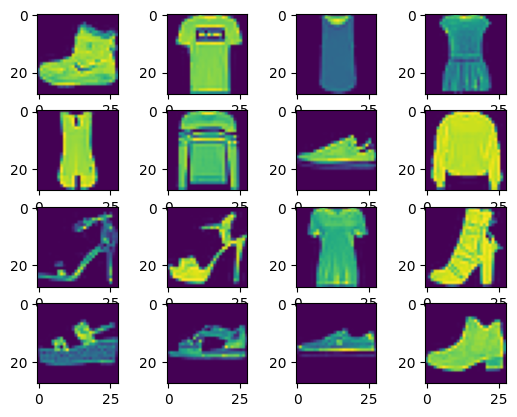

In [19]:
# Define class names (for better understanding)
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
## Write your code here
fig, axs = plt.subplots(4, 4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fm_X_train[i])

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

In [20]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---

#1
fm_X_train_flat = fm_X_train.reshape(fm_X_train.shape[0], -1)
fm_X_test_flat = fm_X_test.reshape(fm_X_test.shape[0], -1)

In [21]:
#2
fm_X_train_scaled = fm_X_train_flat / 255.0
fm_X_test_scaled = fm_X_test_flat / 255.0

In [22]:
#3
log_reg_fm = LogisticRegression(solver='saga', max_iter=300)
log_reg_fm.fit(fm_X_train_scaled[:2000], fm_y_train[:2000])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=300, solver='saga')

In [23]:
#4
fm_y_pred = log_reg_fm.predict(fm_X_test_scaled)
fm_y_pred

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [24]:
#5
print("Classification Report:")
print(classification_report(fm_y_test, fm_y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.96      0.94      0.95      1000
           2       0.65      0.67      0.66      1000
           3       0.82      0.81      0.82      1000
           4       0.67      0.69      0.68      1000
           5       0.91      0.88      0.90      1000
           6       0.51      0.51      0.51      1000
           7       0.88      0.91      0.89      1000
           8       0.92      0.90      0.91      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



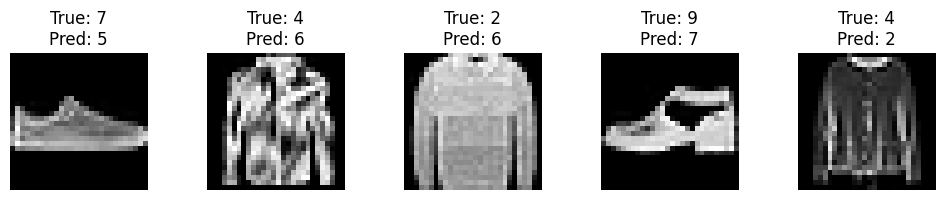

In [25]:
#6
misclassified_indices = np.where(fm_y_pred != fm_y_test)[0]

num_to_display = min(5, len(misclassified_indices))
selected_indices = misclassified_indices[:num_to_display]

plt.figure(figsize=(10, 2))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(fm_X_test[idx], cmap='gray')
    plt.title(f"True: {fm_y_test[idx]}\nPred: {fm_y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [26]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [27]:
# Print the first document and its class
## Write your code here
print(f"First document: {X_train_news[0]}")
print(f"Class of first document: {y_train_news[0]}")

First document: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Class of first document: 7


### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [28]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Initialize TfidfVectorizer for demonstration
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
# The output `sample_vec_output` will be a sparse matrix
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences) # Write your code here

# Convert to a dense NumPy array for easier viewing
sample_vec_output_dense = sample_vec_output_sparse.toarray()

print("\nVocabulary (word to index mapping):")
print(vectorizer.vocabulary_)

print("\nFeature names (words):")
print(vectorizer.get_feature_names_out())

print("\nTF-IDF matrix for sample sentences (dense format):")
print(sample_vec_output_dense)


Vocabulary (word to index mapping):
{'document': 0, 'second': 1}

Feature names (words):
['document' 'second']

TF-IDF matrix for sample sentences (dense format):
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [29]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---
vectorizer_news = TfidfVectorizer(stop_words='english')

In [30]:
X_train_vec = vectorizer_news.fit_transform(X_train_news)

In [31]:
X_test_vec = vectorizer_news.transform(X_test_news)
print(f"Shape of TF-IDF matrix for training data: {X_train_vec.shape}")
print(f"Shape of TF-IDF matrix for test data: {X_test_vec.shape}")
print(f"Number of unique features (words) in vocabulary: {len(vectorizer_news.vocabulary_)}")

Shape of TF-IDF matrix for training data: (11314, 129796)
Shape of TF-IDF matrix for test data: (7532, 129796)
Number of unique features (words) in vocabulary: 129796


In [32]:
log_reg_news = LogisticRegression(solver='saga')

In [33]:
log_reg_news.fit(X_train_vec, y_train_news)

LogisticRegression(solver='saga')

In [34]:
y_pred_news = log_reg_news.predict(X_test_vec)

In [35]:
print("\n--- Classification Report for 20 Newsgroups Logistic Regression ---")
print(classification_report(y_test_news, y_pred_news, target_names=news_test.target_names))

report_news = classification_report(y_test_news, y_pred_news, target_names=news_test.target_names, output_dict=True)
accuracy_news = report_news['accuracy']
avg_precision_news = report_news['macro avg']['precision']
avg_recall_news = report_news['macro avg']['recall']
avg_f1_score_news = report_news['macro avg']['f1-score']

print(f"\nAccuracy: {accuracy_news:.4f}")
print(f"Average Precision (Macro): {avg_precision_news:.4f}")
print(f"Average Recall (Macro): {avg_recall_news:.4f}")
print(f"Average F1-score (Macro): {avg_f1_score_news:.4f}")


--- Classification Report for 20 Newsgroups Logistic Regression ---
                          precision    recall  f1-score   support

             alt.atheism       0.79      0.73      0.76       319
           comp.graphics       0.71      0.80      0.75       389
 comp.os.ms-windows.misc       0.75      0.76      0.75       394
comp.sys.ibm.pc.hardware       0.71      0.74      0.72       392
   comp.sys.mac.hardware       0.80      0.83      0.82       385
          comp.windows.x       0.85      0.75      0.79       395
            misc.forsale       0.78      0.87      0.82       390
               rec.autos       0.90      0.89      0.90       396
         rec.motorcycles       0.94      0.95      0.94       398
      rec.sport.baseball       0.88      0.92      0.90       397
        rec.sport.hockey       0.94      0.96      0.95       399
               sci.crypt       0.95      0.91      0.93       396
         sci.electronics       0.75      0.78      0.76       393
      